<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Проверка-модели-CatBoostRegressor" data-toc-modified-id="Проверка-модели-CatBoostRegressor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Уберем неинформативные признаки и константные признаки: 
- Дату скачивания анкеты из базы.
- Количество фотографий.
- Дату создания анкеты.
- Дата последней активности пользователя.

In [3]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], axis=1)

In [4]:
df.shape

(354369, 12)

Проверим пропущенные значения

In [5]:
pd.DataFrame(round(df.isna().mean() * 100)).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000
Brand,0.000000


Заполним пропуски в признаке "Repaired" значением "no", так как это важная характеристика автомобиля, и случае, если автомобиль был в ДТП, пользователь с большей вероятностью бы отметил это в анкете

In [6]:
df['Repaired'] = df['Repaired'].fillna('no')

Создадим сводную таблицу с типичными характеристиками каждой модели автомобиля, чтобы потом подвязать из неё пропущенные в данных значения

In [7]:
model_char = df.pivot_table(index='Model', values=['VehicleType', 'Gearbox', 'FuelType'], aggfunc='first')
model_char

,FuelType,Gearbox,VehicleType
Model,,,
100,petrol,manual,wagon
145,petrol,manual,small
147,gasoline,manual,sedan
156,petrol,manual,wagon
159,gasoline,manual,sedan
...,...,...,...
yaris,petrol,manual,small
yeti,petrol,manual,suv
ypsilon,petrol,manual,small


Создадим функцию *repair* для подвязки пропущенных значений из сводной таблицы *model_char*, оставшиеся пропущенные значения заполним значением "unknown"

In [8]:
def repair(row):
    for col in model_char.columns:
        if type(row[col]) != str:
            for index in range(model_char.shape[0]):
                if row['Model'] == model_char.index[index]:
                    row[col] = model_char.iloc[index][col]
                    return row
    return row  

In [9]:
df = df.apply(repair, axis=1)

df = df.fillna('unknown')

In [10]:
pd.DataFrame(round(df.isna().mean() * 100)).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000
Brand,0.000000


Избавимся от выбросов в данных

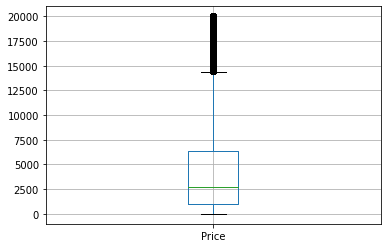

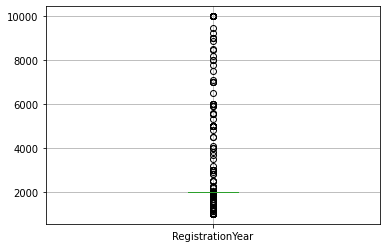

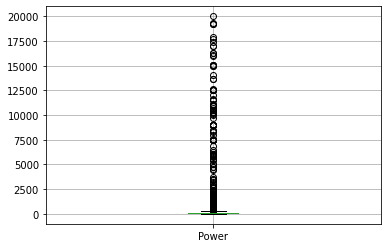

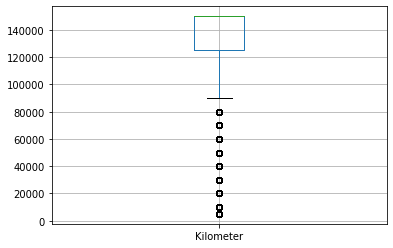

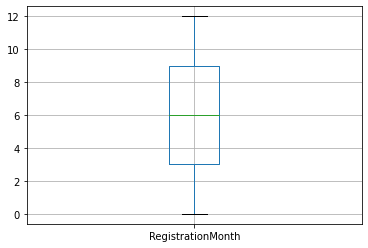

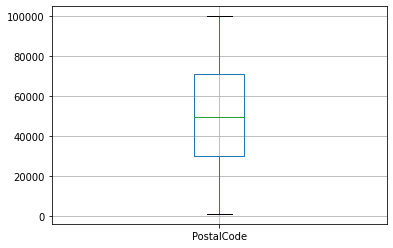

In [11]:
for i in df.columns:
    if type(df[i][0]) != str:
        df.boxplot(column=i)
        plt.show()

In [12]:
df = df.query('Price < =15000 & 1980 <= RegistrationYear <= 2022 & Power <= 300')

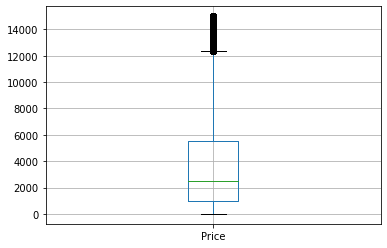

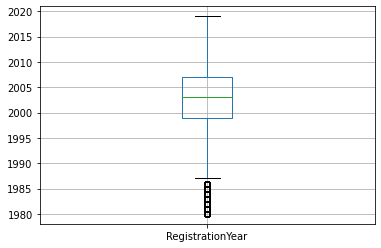

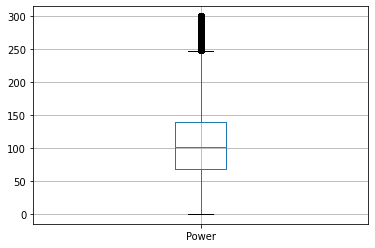

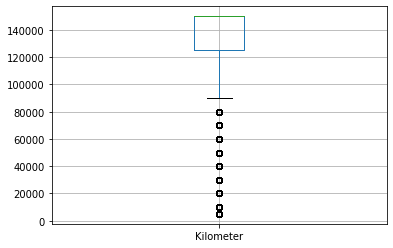

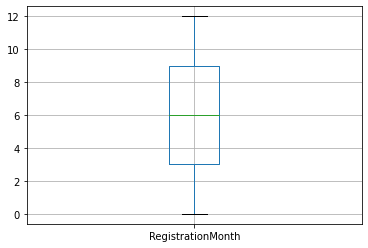

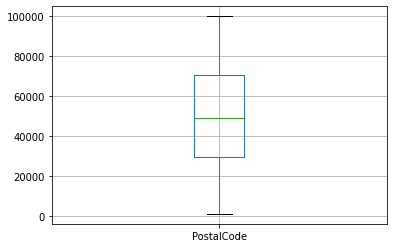

In [13]:
for i in df.columns:
    if type(df[i][0]) != str:
        df.boxplot(column=i)
        plt.show()

Избавившись от пропусков и выбросов в данных, приступим к обучению моделей

## Обучение моделей

Подготовим и разобьем признаки на обучающую, валидационную и тестовую выборки

In [14]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [15]:
X = df.drop(['Price'], axis=1)
y = df['Price']

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=12345)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2,  random_state=12345)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(213602, 11)
(66751, 11)
(53401, 11)
(213602,)
(66751,)
(53401,)


С помощью *LabelEncoder* закодируем категориальные признаки

In [17]:
le = LabelEncoder()

for i in range(len(cat_features)):
    X_train[cat_features[i]] = le.fit_transform(X_train[cat_features[i]])
    X_valid[cat_features[i]] = le.fit_transform(X_valid[cat_features[i]])
    X_test[cat_features[i]] = le.fit_transform(X_test[cat_features[i]])

/tmp/ipykernel_48/1374394246.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[cat_features[i]] = le.fit_transform(X_valid[cat_features[i]])


### LGBMRegressor

In [18]:
%%time
best_model_LGBM = None
n_est = None
depth = None
score = 2500

for n_est in range(20, 101, 10):
    for dep in range(0, 51, 10):
        model_LGBM = LGBMRegressor(learning_rate=.1, n_estimators=n_est, max_depth=dep)
        model_LGBM.fit(X_train, y_train)
        predictions = model_LGBM.predict(X_valid)
        rmse = mean_squared_error(y_valid, predictions) ** .5
        if rmse < score:
            best_model_LGBM = model_LGBM
            n_est = n_est
            depth = dep
            score = rmse
print(f'RMSE модели LGBMRegressor = {score}, n_estimatores = {n_est}, max_depth = {depth}')

RMSE модели LGBMRegressor = 1612.8447004336824, n_estimatores = 100, max_depth = 10
CPU times: user 3min 24s, sys: 805 ms, total: 3min 25s
Wall time: 3min 28s


### CatBoostRegressor

In [19]:
%%time
model_CatBoost = CatBoostRegressor(iterations=100, learning_rate=.1, depth=13, random_state=12345)
model_CatBoost.fit(X_train, y_train, cat_features=cat_features, verbose=20)
predictions = model_CatBoost.predict(X_valid)
rmse = mean_squared_error(y_valid, predictions) ** .5
print(f'RMSE модели CatBoostRegressor = {rmse}')

0:	learn: 3385.3918020	total: 333ms	remaining: 33s
20:	learn: 1720.2255019	total: 5.32s	remaining: 20s
40:	learn: 1534.4169037	total: 10.2s	remaining: 14.7s
60:	learn: 1469.4434037	total: 15.4s	remaining: 9.81s
80:	learn: 1426.0089895	total: 20.4s	remaining: 4.8s
99:	learn: 1391.7483963	total: 25.4s	remaining: 0us
RMSE модели CatBoostRegressor = 1569.8220437175871
CPU times: user 25.7 s, sys: 224 ms, total: 26 s
Wall time: 26.9 s


### RandomForestRegressor

In [20]:
%%time
model_RF = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=12345)
model_RF.fit(X_train, y_train)
predictions = model_RF.predict(X_valid)
rmse = mean_squared_error(y_valid, predictions) **.5
print(f'RMSE модели RandomForestRegressor = {rmse}')

RMSE модели RandomForestRegressor = 1639.37137220159
CPU times: user 49.4 s, sys: 54 ms, total: 49.5 s
Wall time: 49.5 s


Как видно по результатам выше, лучший результат по метрике *RMSE* получила модель *CatBoostRegressor*, самой быстрой (без учета процесса оптимизации) - *LGBMRegressor*, наихудший результат метрики показала *RandomForestRegressor*, за ней же и наихудший показатель скорости выполнения

## Анализ моделей

### LGBMRegressor

In [21]:
%%time
best_model_LGBM.fit(X_train, y_train)

CPU times: user 4.43 s, sys: 32.4 ms, total: 4.47 s
Wall time: 4.52 s


LGBMRegressor(max_depth=10)

In [22]:
%%time
predictions = best_model_LGBM.predict(X_valid)

CPU times: user 511 ms, sys: 0 ns, total: 511 ms
Wall time: 502 ms


In [23]:
score_LGBM = mean_squared_error(y_valid, predictions) **.5

### CatBoostRegressor

In [24]:
%%time
model_CatBoost.fit(X_train, y_train, cat_features=cat_features, verbose=20)

0:	learn: 3385.3918020	total: 281ms	remaining: 27.8s
20:	learn: 1720.2255019	total: 5.2s	remaining: 19.6s
40:	learn: 1534.4169037	total: 10.2s	remaining: 14.7s
60:	learn: 1469.4434037	total: 15.3s	remaining: 9.76s
80:	learn: 1426.0089895	total: 20.4s	remaining: 4.78s
99:	learn: 1391.7483963	total: 25.3s	remaining: 0us
CPU times: user 25.5 s, sys: 220 ms, total: 25.7 s
Wall time: 26.3 s


In [25]:
%%time
predictions = model_CatBoost.predict(X_valid)

CPU times: user 110 ms, sys: 4.03 ms, total: 114 ms
Wall time: 116 ms


In [26]:
score_CatBoost = mean_squared_error(y_valid, predictions) **.5

### RandomForestRegressor

In [27]:
%%time
model_RF.fit(X_train, y_train)

CPU times: user 49.1 s, sys: 18.4 ms, total: 49.1 s
Wall time: 49.2 s


RandomForestRegressor(max_depth=12, random_state=12345)

In [28]:
%%time
predictions = model_RF.predict(X_valid)

CPU times: user 736 ms, sys: 0 ns, total: 736 ms
Wall time: 743 ms


In [29]:
score_RF = mean_squared_error(y_valid, predictions) **.5

In [30]:
LGBM = [0.662, 0.097, score_LGBM]
CB = [7.03, 0.058, score_CatBoost]
RF = [34.5, 0.583, score_RF]

report_RFR = pd.DataFrame([LGBM, CB, RF],
                          columns=['Fit time', 'Predict time', 'Score'],
                          index=['LGBMRegressor', 'CatBoostRegressor', 'RandomForestRegressor'])
report_RFR

,Fit time,Predict time,Score
LGBMRegressor,0.662,0.097,1612.844700
CatBoostRegressor,7.030,0.058,1569.822044
RandomForestRegressor,34.500,0.583,1639.371372


После анализа моделей, можно отметить следующее:
- Самая быстрообучаемая модель - LGBM (~629 мс)
- Самая быстрая модель по скорости выдачи предсказаний - CatBoost (~12 мс)
- Самая точная модель по метрике RMSE - CatBoost (~1570)

## Проверка модели CatBoostRegressor

In [31]:
%%time
predictions = model_CatBoost.predict(X_test)
rmse = mean_squared_error(y_test, predictions) **.5
print(f'Итоговый показатель RMSE модели CatBoost = {rmse}')

Итоговый показатель RMSE модели CatBoost = 1611.1842657100492
CPU times: user 88.6 ms, sys: 4.02 ms, total: 92.6 ms
Wall time: 91.6 ms


По итогам проверки на тестовой выборке, модель *CatBoostRegressor* как по значению метрики *RMSE*, так и по скорости работы подходит под критерии заказчика, на тестовой выборке показатель метрики *RMSE* равен ~1611 и время выполнения блока 96.6 мс.

## Вывод

В ходе исследования были обучены три модели машинного обучения, а именно LGBMRegressor, CatBoostRegressor и RandomForestRegressor, и, опираясь на критерии заказчика, была выбрана модель CatBoostRegressor, с показателями на валидационной выборке RMSE ~1570 (против 1613 у LGBMRegressor и 1639 у RandomForestRegressor), временем выполнения блока 901 мс (против 901 мс у LGBMRegressor и 40.1 с у RandomForestRegressor). Итоговые же показатели модели CatBoostRegressor на тестовой выборке составили ~1611 по метрике качества RMSE, и время исполнения блока 96.6 мс.


Были проделаны следующие шаги:
- Изучен датасет.
- Предобработанны и дозаполненны признаки.
- Обучены и проанализированы 3 модели машинного обучения.
- Выбрана и проверена наилучшая модель, подходящая под требования заказчика.